In [1]:
import pickle
import torch

import gradoptics as optics
from gradoptics.integrator import HierarchicalSamplingIntegrator
from ml.siren import Siren

import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Import scene and targets from Setup notebook

In [2]:
scene_objects = pickle.load(open("NW_mot_scene_components.pkl", "rb"))
targets = pickle.load(open("NW_mot_images.pkl", "rb"))

## Adding a mask to focus on relevant bit of images

In [3]:
sel_mask = torch.ones(targets.shape[1:], dtype=torch.bool)
sel_mask[:250] = 0
sel_mask[1750:] = 0
sel_mask[:, 1500:] = 0

In [4]:
targets = targets.flatten(start_dim=1).cuda()

## Set up model -- here we use SIREN

In [5]:
device = 'cuda'

in_features = 3
hidden_features = 256
hidden_layers = 3
out_features = 1

model = Siren(in_features, hidden_features, hidden_layers, out_features,
              outermost_linear=True, outermost_linear_activation=nn.ReLU()).double().to(device)

## Set up scene used for rendering in training

Relies on new class (make sure to pull) which samples from a neural net for a light source.

In [6]:
# Region we want to integrate in + position
rad = 0.03
obj_pos = (0, 0, 0)

light_source = optics.LightSourceFromNeuralNet(model, optics.BoundingSphere(radii=rad, 
                                                                     xc=obj_pos[0], yc=obj_pos[1], zc=obj_pos[2]),
                                        rad=rad, x_pos=obj_pos[0], y_pos=obj_pos[1], z_pos=obj_pos[2])
scene_train = optics.Scene(light_source)

for obj in scene_objects:
    scene_train.add_object(obj)

/sdf/group/magis/sgaz/sw/conda/envs/ml/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


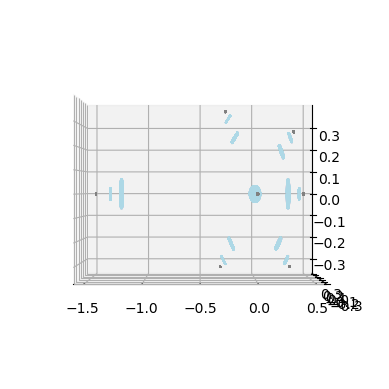

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for obj in scene_train.objects:
    if type(obj) == optics.BoundingSphere:
        continue
        
    obj.plot(ax)
ax.view_init(0, -90)

And now train

In [8]:
sensor_list = [obj for obj in scene_train.objects if type(obj) == optics.Sensor]
lens_list = [obj for obj in scene_train.objects if type(obj) == optics.PerfectLens]

In [ ]:
batch_size = 512
loss_fn = torch.nn.MSELoss()
integrator = HierarchicalSamplingIntegrator(64, 64)
optimizer = torch.optim.Adam(scene_train.light_source.network.parameters(), lr=1e-4)

losses = []

camera_list = torch.randperm(len(targets))
for i_iter in tqdm(range(100000)): 
    # Grab camera image
    rand_data_id = camera_list[i_iter % len(targets)]
    sensor_here = sensor_list[rand_data_id]
    lens_here = lens_list[rand_data_id]
    
    h_here, w_here = sensor_here.resolution
    
    # Grab masked pixel indices + sample randomly
    idxs_all = torch.cartesian_prod(torch.arange(h_here//2, -h_here//2, -1), 
                                    torch.arange(w_here//2, -w_here//2, -1))
    
    idxs_all = idxs_all[sel_mask.flatten()]
    
    rand_pixels = torch.randint(0, len(idxs_all), (batch_size,))
    target_vals = targets[rand_data_id][sel_mask.flatten()][rand_pixels]

    
    batch_pix_x = idxs_all[rand_pixels, 0]
    batch_pix_y = idxs_all[rand_pixels, 1]

    # Render image from neural network light source
    intensities = optics.ray_tracing.ray_tracing.render_pixels(sensor_here, 
                                                  lens_here, 
                                                 scene_train, scene_train.light_source, 1, 5, 
                                                 batch_pix_x, batch_pix_y,
                                                 integrator, device='cuda',max_iterations=6)
    

    # Scaling to help control loss values
    im_scale = targets[rand_data_id][sel_mask.flatten()].mean().item()
    
    # Calculate loss and update neural network parameters
    loss = loss_fn(intensities/im_scale*1e5, target_vals.double().cuda()/im_scale)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record and print out
    losses.append(loss.item())
    if i_iter % 100 == 0:
        print(loss.item())
        
    if i_iter % 500 == 0:
        with torch.no_grad():
            torch.save(scene_train.light_source.network.state_dict(), 
                       f'model_{i_iter}_NW_MOT_all_cameras_long.pt')

  0%|          | 0/100000 [00:00<?, ?it/s]/sdf/home/s/sgaz/gradoptics/src/gradoptics/ray_tracing/ray_tracing.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensor_normal = (lens.transform.transform[:-1, -1]-torch.tensor(sensor.position)).to(device)
  0%|          | 1/100000 [00:05<150:05:11,  5.40s/it]

2.8961176671534523


  0%|          | 3/100000 [00:07<51:00:06,  1.84s/it] /sdf/home/s/sgaz/gradoptics/src/gradoptics/optics/sensor.py:147: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ind // (self.resolution[1] * self.psf_ratio)] += luminosities[arg_ind, None]
  0%|          | 101/100000 [00:49<14:09:17,  1.96it/s]

0.15777480524476373


  0%|          | 201/100000 [01:35<13:59:17,  1.98it/s]

0.8552968469411112


  0%|          | 301/100000 [02:20<12:23:51,  2.23it/s]

0.16578202355848262


  0%|          | 401/100000 [03:03<14:00:09,  1.98it/s]

0.8721471075059393


  1%|          | 501/100000 [03:47<11:39:01,  2.37it/s]

0.18703121390859734


  1%|          | 601/100000 [04:30<9:32:04,  2.90it/s] 

0.6667149916473538


  1%|          | 701/100000 [05:15<9:38:02,  2.86it/s] 

0.16226676451405886


  1%|          | 801/100000 [06:01<13:37:38,  2.02it/s]

0.6955743456057534


  1%|          | 901/100000 [06:46<16:02:32,  1.72it/s]

0.21841744697753335


  1%|          | 1001/100000 [07:31<13:09:56,  2.09it/s]

0.7587352936721322


  1%|          | 1101/100000 [08:16<9:46:54,  2.81it/s] 

0.24478501790843207


  1%|          | 1201/100000 [08:59<11:29:02,  2.39it/s]

0.6926215957432783


  1%|▏         | 1301/100000 [09:44<14:45:15,  1.86it/s]

0.1890219945197419


  1%|▏         | 1401/100000 [10:30<15:00:06,  1.83it/s]

0.5675041561897312


  2%|▏         | 1500/100000 [11:12<13:59:05,  1.96it/s]

0.17240121462072192


  2%|▏         | 1601/100000 [11:55<12:47:02,  2.14it/s]

0.7685091675330277


  2%|▏         | 1701/100000 [12:38<9:15:45,  2.95it/s] 

0.19910707478597073


  2%|▏         | 1801/100000 [13:22<9:28:20,  2.88it/s] 

0.8853550433420039


  2%|▏         | 1901/100000 [14:06<9:50:46,  2.77it/s] 

0.17112270589131462


  2%|▏         | 2001/100000 [14:49<9:33:46,  2.85it/s] 

0.9587196516234353


  2%|▏         | 2101/100000 [15:33<9:26:57,  2.88it/s] 

0.16076527225761142


  2%|▏         | 2201/100000 [16:17<9:09:09,  2.97it/s] 

0.6887525802232397


  2%|▏         | 2301/100000 [17:00<9:10:06,  2.96it/s] 

0.15866527337570374


  2%|▏         | 2401/100000 [17:46<13:22:40,  2.03it/s]

0.8617780950793645


  3%|▎         | 2501/100000 [18:30<13:00:37,  2.08it/s]

0.17916044543638626


  3%|▎         | 2801/100000 [20:40<13:51:24,  1.95it/s]

0.7455837244937092


  3%|▎         | 2901/100000 [21:26<16:37:46,  1.62it/s]

0.19586375566349423


  3%|▎         | 3001/100000 [22:11<13:59:25,  1.93it/s]

0.7273038655096367


  3%|▎         | 3101/100000 [22:53<13:16:19,  2.03it/s]

0.18410340004161463


  3%|▎         | 3201/100000 [23:37<13:34:15,  1.98it/s]

0.7982374170662383


  3%|▎         | 3301/100000 [24:20<12:00:23,  2.24it/s]

0.16186775967520847


  3%|▎         | 3401/100000 [25:04<9:47:10,  2.74it/s] 

0.8373498693087724


  4%|▎         | 3501/100000 [25:48<9:21:18,  2.87it/s] 

0.17242868796190103


  4%|▎         | 3601/100000 [26:31<9:32:35,  2.81it/s] 

0.8102717519401961


  4%|▎         | 3701/100000 [27:15<9:12:13,  2.91it/s] 

0.18148687306460065


  4%|▍         | 3801/100000 [27:58<9:10:07,  2.91it/s] 

0.7723602159908035


  4%|▍         | 3901/100000 [28:41<9:09:45,  2.91it/s] 

0.16774720121352066


  4%|▍         | 4201/100000 [30:56<14:41:52,  1.81it/s]

0.7120730709834123


  4%|▍         | 4301/100000 [31:41<14:50:56,  1.79it/s]

0.12298767597775905


  4%|▍         | 4401/100000 [32:25<11:13:39,  2.37it/s]

0.7366083101124756


  5%|▍         | 4501/100000 [33:09<9:21:54,  2.83it/s] 

0.1931458353520551


  5%|▍         | 4601/100000 [33:52<8:57:48,  2.96it/s] 

0.8753529173058037


  5%|▍         | 4701/100000 [34:35<9:15:23,  2.86it/s] 

0.19213940156655962


  5%|▍         | 4801/100000 [35:18<8:59:10,  2.94it/s] 

0.7875635132907949


  5%|▍         | 4901/100000 [36:03<12:11:02,  2.17it/s]

0.16162617105290117


  5%|▌         | 5001/100000 [36:45<9:22:28,  2.81it/s] 

0.864898593070369


  5%|▌         | 5101/100000 [37:30<14:30:17,  1.82it/s]

0.16091196731367635


  5%|▌         | 5201/100000 [38:14<12:24:55,  2.12it/s]

0.6976758697010321


  5%|▌         | 5301/100000 [38:58<12:35:47,  2.09it/s]

0.1701846950337766


  5%|▌         | 5401/100000 [39:42<12:49:05,  2.05it/s]

0.7912596400614418


  6%|▌         | 5501/100000 [40:25<14:16:43,  1.84it/s]

0.22059733441830134


  6%|▌         | 5601/100000 [41:08<14:15:26,  1.84it/s]

0.6401402349546517


  6%|▌         | 5701/100000 [41:52<13:26:34,  1.95it/s]

0.17052799718455414


  6%|▌         | 5801/100000 [42:35<13:44:13,  1.90it/s]

0.6819014614754028


  6%|▌         | 5901/100000 [43:20<13:46:23,  1.90it/s]

0.18448628407592726


  6%|▌         | 6001/100000 [44:05<11:23:39,  2.29it/s]

0.8931224622877092


  6%|▌         | 6101/100000 [44:48<9:12:49,  2.83it/s] 

0.13512359735030144


  6%|▌         | 6201/100000 [45:32<10:14:26,  2.54it/s]

0.9725465192544172


  6%|▋         | 6301/100000 [46:15<8:48:08,  2.96it/s] 

0.20640019364258066


  6%|▋         | 6401/100000 [46:58<8:54:00,  2.92it/s] 

0.7448648010805441


  7%|▋         | 6501/100000 [47:42<9:20:55,  2.78it/s] 

0.23089103018154314


  7%|▋         | 6542/100000 [48:01<8:59:34,  2.89it/s] 